In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
import math

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#Set GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [3]:
#build data generators for training and validaton

split = 0.2

# Define dirs and files
train_data_dir = '../data/pics/labelertoModel/AllRoundsSeven'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale =1./255.,
                                   rotation_range = 90,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.45,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set Image size (RGB so imshape is 3)
pix_dim = 512
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

# Flow training images in batches 
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'binary',
                                                    target_size = imsize,
                                                    subset='training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_directory(train_data_dir, # same directory as training data,
                                                        batch_size = batch_size,
                                                        class_mode = 'binary',
                                                        target_size = imsize,
                                                        subset='validation')

Found 2741 images belonging to 2 classes.
Found 684 images belonging to 2 classes.


In [20]:
total_train = 2741
total_val = 684

In [21]:
# define the metrics
acc_metric = tf.keras.metrics.BinaryAccuracy(name='acc')

In [22]:
#load or build model
##########

#from scratch:
#base model, no top layer, w/ imagenet weights
base_model = tf.keras.applications.ResNet50(input_shape = imshape, 
                                             include_top = False, 
                                             weights = None)

# to freeze the batch Norm layers
#base_model.training = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
# add a new classifcation layer
final_layer = base_model.get_layer('conv5_block3_out')
#print('shape of last layer is ', final_layer.output_shape)
final_base_output = final_layer.output

# add avg pool
x = layers.GlobalAveragePooling2D(name='avg_pool')(final_base_output)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)   

      
#make the model trainable (even though the batch norm layers are frowqzen from Training = False)
#base_model.trainable = True

model = Model(base_model.input, x) 
#############
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [9]:
# # #LR determination
# callbacks = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/10))

# # #build the model
# model.compile(loss = 'binary_crossentropy',
#               optimizer = tf.keras.optimizers.RMSprop(lr = 1e-8),
#               metrics = acc_metric)

# #train the model
# history = model.fit(train_generator,
#                     steps_per_epoch = total_train // batch_size,
#                     #validation_data = validation_generator,
#                     epochs= 100,
#                     #validation_steps =  total_val // batch_size,
#                     workers = 24,
#                     callbacks =[callbacks])

Text(0.5, 1.0, 'Loss (y) as a fn of RMSprop Learning rate (x)')

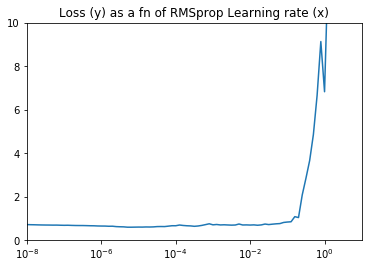

In [12]:
# #plot the loss curve
# lrs  = 1e-8 * (10 ** (np.arange(100) / 10))
# plt.semilogx(lrs, history.history["loss"])
# plt.axis([1e-8, 10, 0, 10])
# plt.title('Loss (y) as a fn of RMSprop Learning rate (x)')

In [24]:
# define a callback

callbacks = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', 
                                             patience = 20, 
                                             restore_best_weights = True)

#build the model
model.compile(loss = 'binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr = 1e-5),
              metrics = acc_metric)



In [ ]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 100,
                    validation_steps =  total_val // batch_size,
                    workers = 24,
                    callbacks =[callbacks])

Epoch 1/100
171/171 [==============================] - 109s 635ms/step - loss: 0.6669 - acc: 0.5982 - val_loss: 0.7024 - val_acc: 0.4003
Epoch 2/100
171/171 [==============================] - 103s 602ms/step - loss: 0.6361 - acc: 0.6341 - val_loss: 0.8007 - val_acc: 0.4807
Epoch 3/100
171/171 [==============================] - 105s 616ms/step - loss: 0.6091 - acc: 0.6719 - val_loss: 0.9000 - val_acc: 0.4092
Epoch 4/100
171/171 [==============================] - 102s 598ms/step - loss: 0.5996 - acc: 0.6811 - val_loss: 0.8897 - val_acc: 0.5312
Epoch 5/100
171/171 [==============================] - 104s 610ms/step - loss: 0.6057 - acc: 0.6745 - val_loss: 0.8842 - val_acc: 0.4955
Epoch 6/100
171/171 [==============================] - 103s 603ms/step - loss: 0.5879 - acc: 0.6862 - val_loss: 0.9165 - val_acc: 0.5699
Epoch 7/100
171/171 [==============================] - 103s 602ms/step - loss: 0.5676 - acc: 0.6983 - val_loss: 1.3344 - val_acc: 0.5372
Epoch 8/100
171/171 [====================

In [ ]:
#look at the metrics from training
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

plt.plot(epochs, loss, 'r--', label='Training loss')
plt.plot(epochs, val_loss, 'b--', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
#save the model
filepath = './models/VGG16_model_7_8020split_512px_resnet50'
model.save(filepath)

#load model
#model = tf.keras.models.load_model(filepath, compile = True)